# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

### 0.2 测试数据生成

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:293: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:293: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:293: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:293: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:323: UserWarning: Matplotlib is currently using module://ma

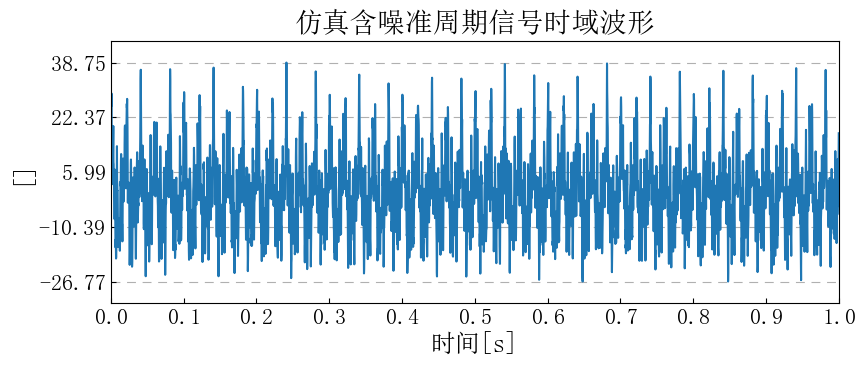

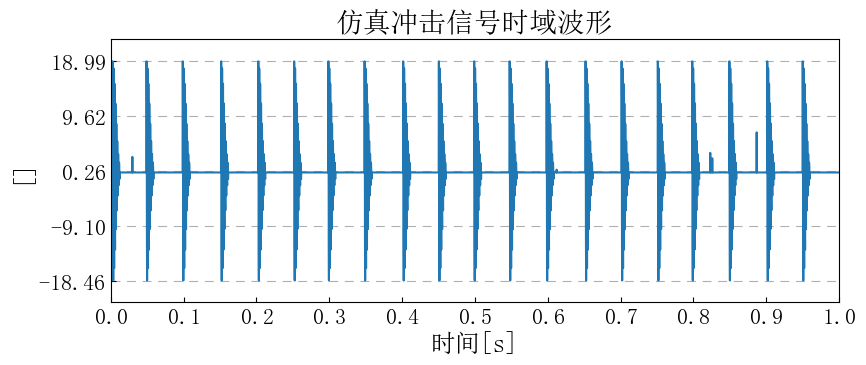

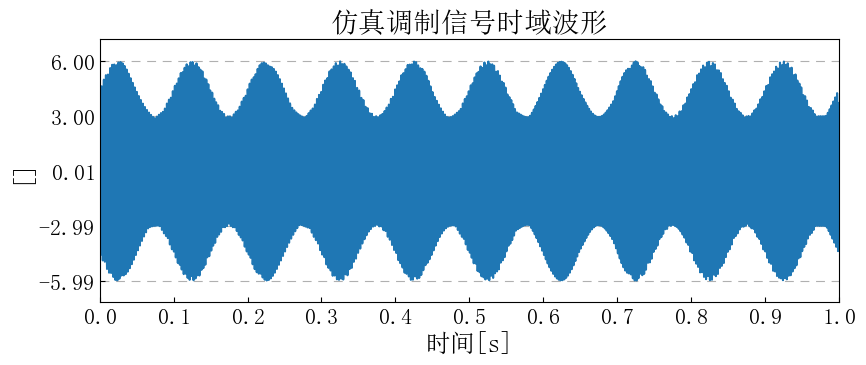

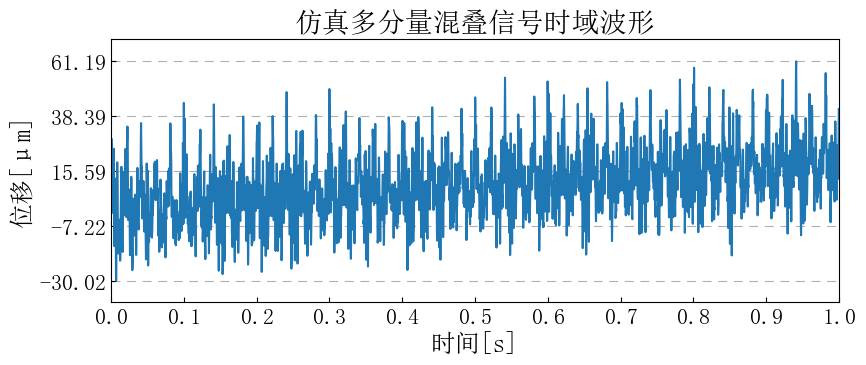

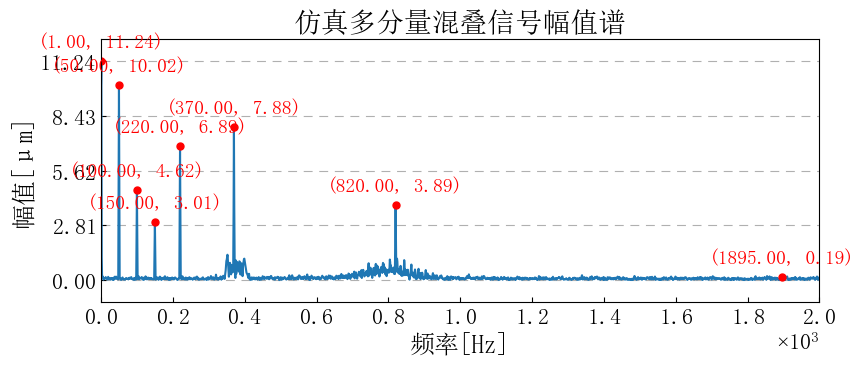

In [2]:
from PySP.Signal import t_Axis,Signal,Periodic, Impulse, Modulation
from PySP.Analysis import SpectrumAnalysis

Sig= Signal(t_Axis(fs=4000.0,T=1.0), name="位移", unit="μm", label="仿真多分量混叠信号")

# 多个谐波分量
Sig1= Periodic(fs=Sig.t_axis.fs, T=Sig.t_axis.T, CosParams=((50,10,94),(100,4.5,43),(150,3.1,-58)),noise=2.0)
Sig1+= Periodic(fs=Sig.t_axis.fs, T=Sig.t_axis.T, CosParams=((220,6.8,0),(370,8.0,30),(820,4.2,-30)),noise=1.0)
Sig1.plot()
Sig+= Sig1

# 冲击序列
Sig2= Impulse(fs=Sig.t_axis.fs,T=Sig.t_axis.T, ImpParams=(800,20,0.05,20,0.01),noiseParams=(5,2))
Sig2.plot()
Sig+= Sig2

# 快变调频分量
def AM(t):
    return (0.5*np.sin(2*np.pi*10*t)+1.5)*3
def FM(t):
    return 50*t + 20*np.sin(2*np.pi*2*t)
Sig3= Modulation(fs=Sig.t_axis.fs,T=Sig.t_axis.T,fc=350.0, AM=AM, FM=FM)
Sig3.plot()
Sig+= Sig3

# 趋势分量
Sig += np.linspace(0, 20, len(Sig))


Sig.plot()
res = SpectrumAnalysis(Sig, isPlot=True).cft()

## 1. Signal模块测试

### 1.1 core

#### .Axis()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Axis,t_Axis

# --------------------------------------------------------------------------------------------#
# 辅助接口


# --------------------------------------------------------------------------------------------#
# 测试过程

axis= Axis(N=10000,dx=0.1,x0=1.0,name="x",unit='u')
t_axis= t_Axis(len(axis),fs=1000.0)

print(axis)
print(t_axis)

#### .Series()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Series

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Axis

# --------------------------------------------------------------------------------------------#
# 测试过程

axis = Axis(N=5000, dx=0.01, x0=0.0, name="时间", unit="s")
data = np.random.rand(5000)
Srs = Series(
    axis=axis, data=data, name="位移", unit="μm", label="测试信号"
)
print(Srs)

#### .Signal()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Signal
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程

Sig = Signal(
    axis=Sig.t_axis, data=Sig.data, name="位移", unit="μm", label="测试信号"
)
print(Sig)
res=Sig.plot(xlim=(0,0.1))

#### .Spectra()

Spectra[测试信号](幅值=[2.87457982e-17 4.39867748e-17 3.32677715e-17 ... 2.47843984e-16
 8.82169374e-17 1.13344793e-16][μm], f_Axis(频率=[0.000e+00 1.000e+00 2.000e+00 ... 1.998e+03 1.999e+03 2.000e+03][Hz]))


f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:273: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Signal_Module\core.py:1084: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 900x400 with 1 Axes>,
 array([<AxesSubplot:title={'center':'测试信号幅值谱'}, xlabel='频率[Hz]', ylabel='幅值[μm]'>],
       dtype=object))

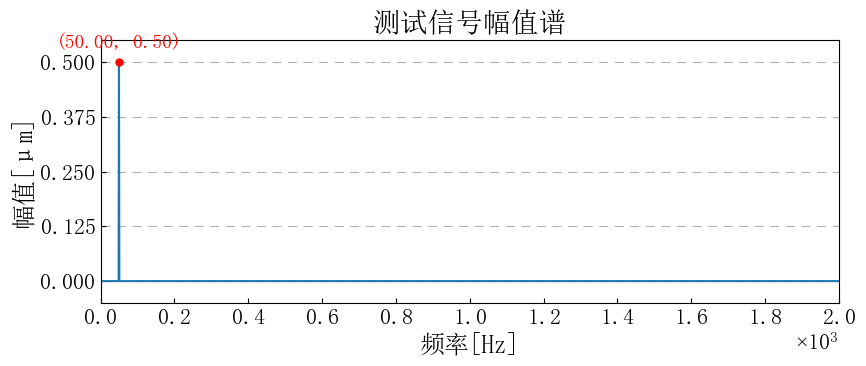

In [22]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Spectra

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
data=np.abs(np.fft.rfft(np.sin(2*np.pi*50*Sig.t_axis())))/len(Sig)
Spc = Spectra(
    axis=Sig.f_axis[:len(data)], data=data, name="幅值", unit="μm", label="测试信号"
)
print(Spc)
Spc.plot(peak_distance=10, peak_threshold=0.5)

### 1.2 SignalSampling

#### .Resample()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Resample

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import t_Axis,Signal

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig= Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号")
_Sig= Resample(Sig,type='extreme', dt=Sig.t_axis.dt*2, t0=1.0, T=1.0)
_Sig.label="重采样测试信号"
print(_Sig)
_Sig.plot()

### 1.3 SimulateSignal

#### .Periodic()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Periodic

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Periodic(fs=1000.0, T=2.0, CosParams=((20, 1, 32), (50, 0.5, 0)), noise=1.0)
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

#### .Impulse()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Impulse

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Impulse(fs=10000.0, T=2.0, ImpParams=(1000, 10, 0.1, 0.3*np.sin(2 * np.pi * 2 * Sig.t_axis())+1, 0.05), noiseParams=(10, 1))
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

#### .Modulation()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Modulation

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Modulation(fs=1000.0, T=2.0, fc=100.0, AM=lambda t: 1 + 0.5 * np.sin(2 * np.pi * 5 * t), FM=lambda t: 50 * np.sin(2 * np.pi * 1 * t))
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

### 1.4 SignalRead

#### .Files()

In [150]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Files

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Files.set_read_params(".csv", names=["水平", "垂直"], skiprows=1)
f = Files(
    names=[str(n) + ".csv" for n in range(1, 100)],
    root=r"F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\学术公开数据集\xjtu_轴承加速退化振动数据集\Datasets\40Hz10kN\Bearing3_4",
    type=".csv",
)

#### .DataSet()

In [155]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Dataset

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Files

# --------------------------------------------------------------------------------------------#
# 测试过程
Files.set_read_params(
    ".csv",
    index_col=False,
    header=None,
    names=["CH1", "CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8"],
    sep=",",
    skiprows=16,
)
ds = Dataset(
    root=r"F:\OneDrive\用户文件\科研学习\机械故障诊断数据库\学术公开数据集\seu_齿轮箱故障振动数据集\gearbox",
    type="csv",
    label="东南大学齿轮箱故障数据集",
)

In [160]:
ds.content['bearingset']['Files'][0].load(merge=True)

,ball_20_0/CH1,ball_20_0/CH2,ball_20_0/CH3,ball_20_0/CH4,ball_20_0/CH5,ball_20_0/CH6,ball_20_0/CH7,ball_20_0/CH8
0,-0.131940,-0.003675,-0.007886,-0.006003,-0.009137,0.004551,0.000236,0.000334
1,-0.134883,-0.000161,0.003791,0.004156,-0.002578,0.006244,-0.002215,-0.007107
2,-0.136186,-0.000046,-0.002126,-0.000608,0.002059,0.000831,0.000814,0.000023
3,-0.134126,-0.000200,-0.001577,-0.003772,-0.001578,-0.001233,-0.000161,0.004441
4,-0.136193,0.001631,0.002419,0.004975,-0.006818,-0.007070,-0.002962,0.001920
...,...,...,...,...,...,...,...,...
1048555,-0.136644,-0.001228,-0.005304,0.002154,0.005057,0.007437,0.003976,-0.004729
1048556,-0.135646,0.001791,0.002497,0.001574,0.000437,-0.001198,0.006135,-0.012242
1048557,-0.137790,0.002385,-0.001674,0.001507,0.001581,-0.003831,-0.001885,-0.001711
1048558,-0.140858,0.005471,0.008260,0.001360,0.008322,-0.004454,0.001184,0.005413


## 2. Plot模块测试

### 2.1 core

#### .Plot()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import Plot
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(
    axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号"
)
class TestPlot(Plot):
    def plot(self, Sig: 'Signal', **kwargs):
        def _draw_plot(ax, data):
            ax.plot(data.__axis__(), data.data, label=data.label)
        task_kwargs = self.kwargs
        task_kwargs.update(kwargs)
        task = {
            "data": Sig,
            "kwargs": task_kwargs,
            "function": _draw_plot,
            "plugins": [], 
        }
        self.tasks.append(task)
        return self
test=TestPlot(xlabel="时间/s", ylabel="幅值", title="Plot.Plot()",).plot(Sig).show()

### 2.2 LinePlot

#### .LinePlot()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import LinePlot
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis, Resample
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig1 = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号1")
Sig2 = (Sig1 + 2) * 3 + 10
Sig2.label = "测试信号2"
Sig2 = Resample(Sig=Sig2, dt=Sig1.t_axis.dt*4, t0=2.0, T=1.0)
Plot = LinePlot(isSampled=True, title="Plot.LinePlot()")
Plot.timeWaveform(Sig1, ybins=7)
Plot.timeWaveform(Sig2)
Plot.show(pattern='return')
import matplotlib.pyplot as plt
plt.show()

### 2.3 Plugins

#### .PeakfinderPlugin()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import PeakfinderPlugin
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Plot import LinePlot
from PySP.Signal import Spectra
from scipy.fftpack import fft
# --------------------------------------------------------------------------------------------#
# 测试过程
Plot = LinePlot(isSampled=True, figsize=(10, 4), title="Plot.PeakfinderPlugin()")
Plot.timeWaveform(Sig)
F_x = np.abs(fft(Sig.data)) / len(Sig)*2
Spc= Spectra(axis=Sig.f_axis, data=F_x, name="幅值", unit="um", label="测试信号")
Plot.waveform(Spc)
Plot.set_params_to_task(xlim=(0,1000), title="频谱")
Plot.add_plugin_to_task(
    PeakfinderPlugin()
)
Plot.show()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import find_spectralines
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
find_spectralines(Spc.data)

## 3. Analysis模块测试

### 3.1 core

#### .Analysis()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import Analysis
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import f_Axis, Signal, t_Axis
from PySP.Plot import timeWaveform_PlotFunc, freqSpectrum_PlotFunc
from scipy.signal import hilbert
# --------------------------------------------------------------------------------------------#
# 测试过程
class TestAnalysis(Analysis):
    @Analysis.Plot(timeWaveform_PlotFunc)
    def envelope(self):
        """包络分析"""
        analytic_signal = hilbert(self.Sig.data)
        amplitude_envelope = np.abs(analytic_signal)
        return Signal(axis=t_Axis(len(amplitude_envelope), fs=self.Sig.t_axis.fs, t0=self.Sig.t_axis.t0), data=amplitude_envelope, label="包络信号")
    @Analysis.Plot(freqSpectrum_PlotFunc)
    def fft(self):
        """FFT频谱分析"""
        N = len(self.Sig)
        Y = np.fft.fft(self.Sig.data)
        P2 = np.abs(Y / N)  # 双边频谱
        P1 = P2[: N // 2 + 1]  # 单边频谱
        P1[1:-1] = 2 * P1[1:-1]
        f = self.Sig.t_axis.fs * np.arange(0, (N / 2 + 1)) / N
        f = f_Axis(len(P1), df=self.Sig.f_axis.df)
        return Spectra(axis=f, data=P1, name="幅值", unit="um", label="测试信号")
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号")
analysis = TestAnalysis(Sig, isPlot=True, title="频谱")
analysis.fft()
analysis.plot_kwargs['title'] = "包络"
res=analysis.envelope()

### 3.2 SpectrumAnalysis

#### .window()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import Window
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
data = Window(type="汉宁窗", num=1000, padding=50)
res = Signal(axis=t_Axis(len(data), fs=fs), data=data, label="汉宁窗")
print(res)
res.plot()

#### .find_spectralines()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import find_spectralines
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
find_spectralines(Spc.data)

#### .SpectrumAnalysis()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import SpectrumAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
analysis = SpectrumAnalysis(Sig, isPlot=True, yscale='linear')
analysis.cft()
analysis.psd()

### 3.3 ModeAnalysis

#### .EMDAnalysis()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import EMDAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig.plot()
IMFs=EMDAnalysis(Sig,isPlot=True,stopDec_weakness=2e-1,stopSift_times=5).emd()

#### .VMDAnalysis()

In [ ]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import VMDAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig.plot()
res=VMDAnalysis(Sig,isPlot=True).vmd(decNum=3,iterations=11,bw=200,tau=0.1,threshold=1e-1)